# Project 3 — Job Change Prediction (aug_train.csv)

This notebook predicts job change using K-Means and Logistic Regression.


# 1. Import Library

In [2]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
RANDOM_STATE = 42

print("Library imported successfully")

Library imported successfully


## 2. Load dataset & quick inspection


In [3]:
# Load the dataset
df = pd.read_csv("aug_train.csv")
print("Shape:", df.shape)
display(df.head())
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values per column:")
display(df.isnull().sum())


Shape: (19158, 14)


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0



Columns:
 ['enrollee_id', 'city', 'city_development_index', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job', 'training_hours', 'target']

Missing values per column:


enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

> Observations to note:
> - `target` is the supervised label.  
> - Many categorical columns have missing values (`gender`, `enrolled_university`, `education_level`, `major_discipline`, `company_size`, `company_type`, `last_new_job`).  
> - `experience` and `training_hours` and `city_development_index` are numeric-ish but `experience` contains strings like '>20', '<1' — we'll convert that.


## 3. Missing value handling (mode/median/mean/domain rules)
Strategy:
- `gender`, `enrolled_university`, `education_level`, `major_discipline`, `company_size`, `company_type`, `last_new_job` → **mode** (most frequent)  
- `experience` → convert special tokens ('<1' -> 0.5, '>20' -> 21) then impute median  
- `city_development_index` and `training_hours` have no missing values in this dataset snapshot; if they did, use median


In [4]:
data = df.copy()

# 1) Clean/convert 'experience' to numeric
# Replace '>20' -> 21, '<1' -> 0.5 and convert to float; then fill missing with median
data['experience'] = data['experience'].replace({'>20': '21', '<1': '0.5', 'nan': np.nan})
data['experience'] = pd.to_numeric(data['experience'], errors='coerce')
exp_median = data['experience'].median()
data['experience'].fillna(exp_median, inplace=True)

# 2) last_new_job: replace 'never' with 0, '>4' with 5 (or keep as numeric categories) and impute mode
data['last_new_job'] = data['last_new_job'].replace({'never': 0, '>4': 5})
# convert to numeric where possible
data['last_new_job'] = pd.to_numeric(data['last_new_job'], errors='coerce')
# impute mode for remaining nulls
if data['last_new_job'].isnull().sum() > 0:
    data['last_new_job'].fillna(data['last_new_job'].mode()[0], inplace=True)

# 3) Impute categorical columns with mode
cat_mode_cols = ['gender','enrolled_university','education_level','major_discipline','company_size','company_type']
for col in cat_mode_cols:
    if col in data.columns:
        data[col].fillna(data[col].mode()[0], inplace=True)

# 4) Ensure numeric columns have no missing values; use median if any left
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

print("Missing values after imputation:")
display(data.isnull().sum())


Missing values after imputation:


enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

## 4. Quick EDA & visualizations
- Target distribution  
- Some categorical frequency plots  
- Numeric distributions & relationships


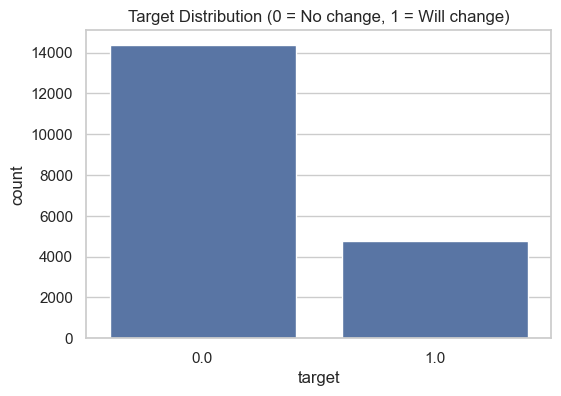

target
0.0    0.750652
1.0    0.249348
Name: proportion, dtype: float64

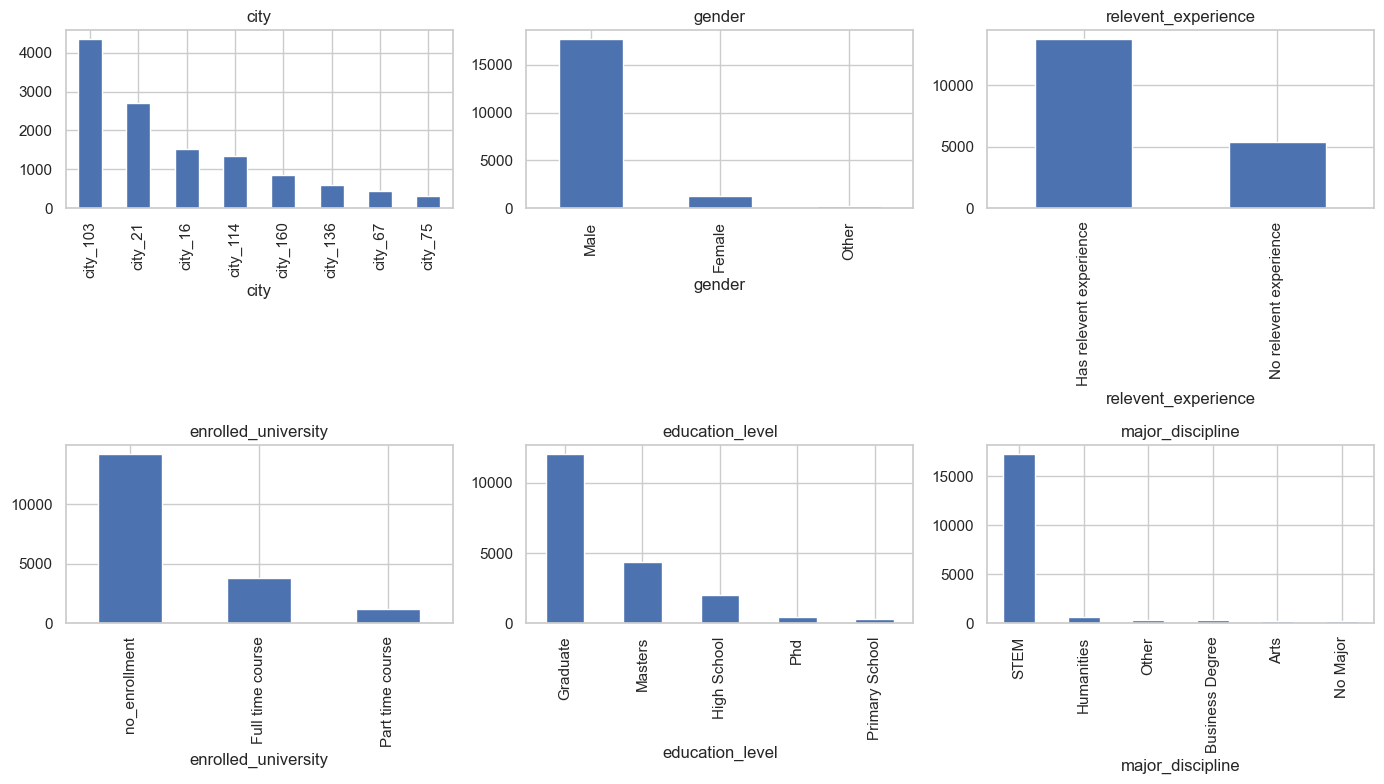

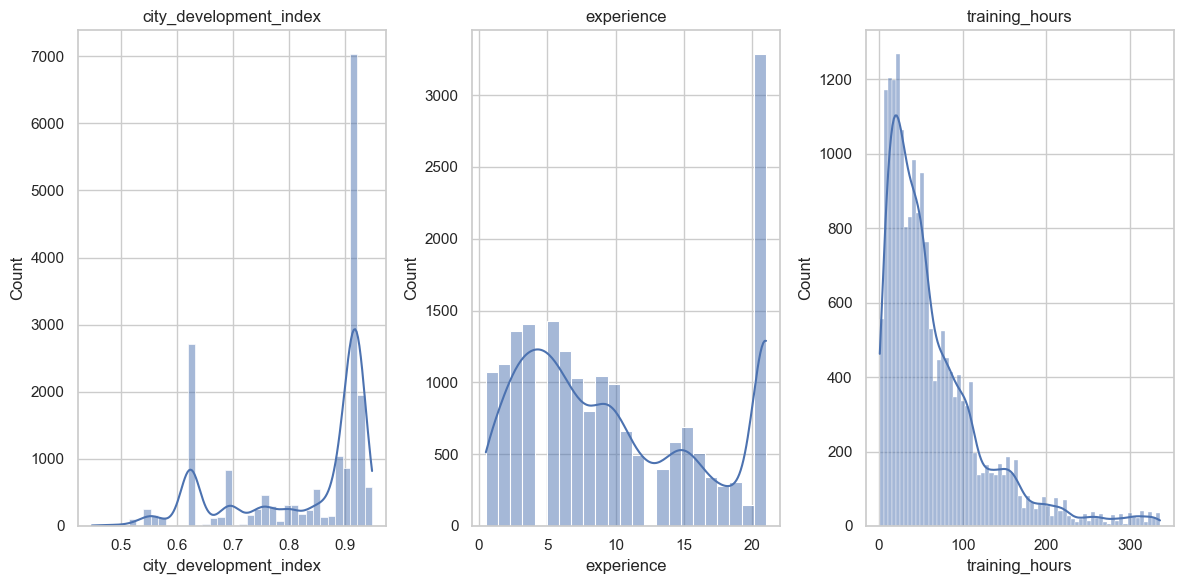

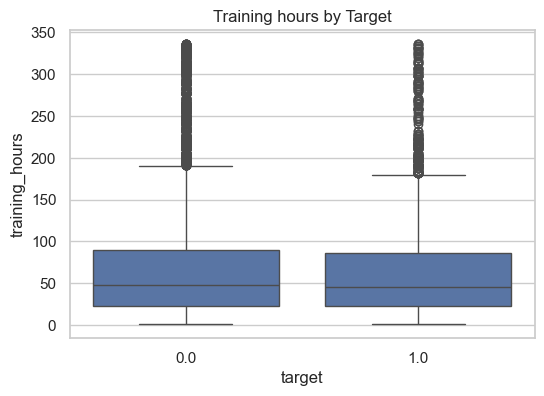

In [5]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=data)
plt.title('Target Distribution (0 = No change, 1 = Will change)')
plt.show()
display(data['target'].value_counts(normalize=True))

# Key categorical value counts
plt.figure(figsize=(14,8))
for i, col in enumerate(['city','gender','relevent_experience','enrolled_university','education_level','major_discipline'],1):
    plt.subplot(2,3,i)
    data[col].value_counts().nlargest(8).plot(kind='bar')
    plt.title(col)
plt.tight_layout()
plt.show()

# Numeric feature distributions
plt.figure(figsize=(12,6))
for i, col in enumerate(['city_development_index','experience','training_hours'],1):
    plt.subplot(1,3,i)
    sns.histplot(data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Boxplot: training_hours by target
plt.figure(figsize=(6,4))
sns.boxplot(x='target', y='training_hours', data=data)
plt.title('Training hours by Target')
plt.show()


> EDA notes to mention in report:  
> - Class balance: check proportions (often imbalanced).  
> - `training_hours`, `experience`, and `city_development_index` show informative spreads.  
> - Some categories (company_size, major_discipline) have many missing values but were filled with mode — consider treating 'Unknown' separately in advanced work.


## 5. Preprocessing & encoding pipeline
We will:
- Keep `enrollee_id` aside (not a feature).  
- Encode categorical variables using OneHotEncoder for nominal columns and Ordinal where appropriate (we will use OneHot for most).  
- Scale numeric features with StandardScaler.  
- Prepare two datasets:
  - For clustering (unsupervised): use numeric features scaled.
  - For Logistic Regression: use encoded features.


In [6]:
# Drop enrollee_id
data_model = data.drop(columns=['enrollee_id'])

# Separate features and target
X = data_model.drop('target', axis=1)
y = data_model['target'].astype(int)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical cols:", categorical_cols)
print("Numerical cols:", numerical_cols)


Categorical cols: ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type']
Numerical cols: ['city_development_index', 'experience', 'last_new_job', 'training_hours']


In [8]:
# ColumnTransformer: OneHot encode categorical; scale numeric separately using pipeline

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
], remainder='drop', sparse_threshold=0)

# Transform full feature set for logistic regression
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(ohe_cols)

print("Feature matrix shape:", X_preprocessed.shape)


Feature matrix shape: (19158, 160)


## 6. K-Means Clustering (unsupervised exploration)
- Run elbow method to find good K  
- Compute silhouette score  
- Profile clusters (how they map to `target`)


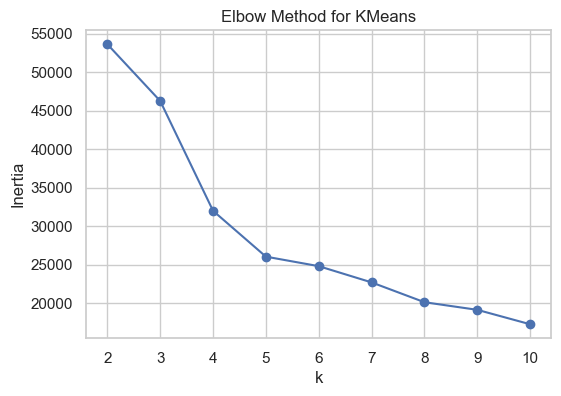

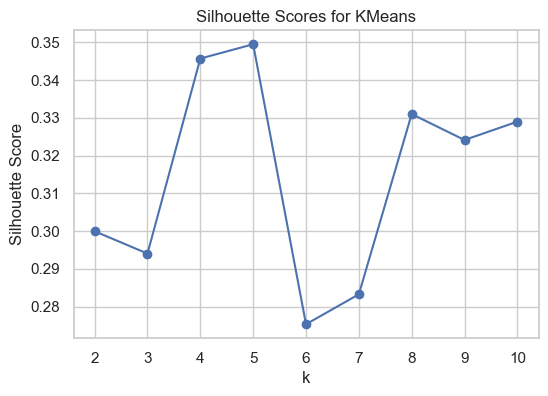

Best k by silhouette: 5
Cluster counts:


cluster
4    5885
2    4503
3    3908
0    3154
1    1708
Name: count, dtype: int64


Target distribution per cluster:


target,0.0,1.0
cluster,,
0,0.857,0.143
1,0.807,0.193
2,0.503,0.497
3,0.830,0.170
4,0.814,0.186


In [9]:
# For clustering, use numerical features scaled
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X[numerical_cols])

# Elbow method
inertia = []
K_range = range(2,11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_num_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans')
plt.show()

# Silhouette scores
sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_num_scaled)
    sil = silhouette_score(X_num_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(K_range, sil_scores, '-o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for KMeans')
plt.show()

# Choose k (pick k with good silhouette & elbow; we pick k=4 as example — adjust after visual)
best_k = int(K_range[np.argmax(sil_scores)])
print("Best k by silhouette:", best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=RANDOM_STATE)
cluster_labels = kmeans_final.fit_predict(X_num_scaled)
# Attach cluster labels
data_clustered = data_model.copy()
data_clustered['cluster'] = cluster_labels

# Profile clusters vs target
print("Cluster counts:")
display(data_clustered['cluster'].value_counts())
print("\nTarget distribution per cluster:")
display(pd.crosstab(data_clustered['cluster'], data_clustered['target'], normalize='index').round(3))


> Use these cluster profiles in your report: e.g., cluster 0 has higher share of `target=1` and strong training_hours/experience patterns — this suggests cluster membership helps predict willingness to change job.


## 7. Logistic Regression — train & evaluate
We will:
- Train-test split  
- Fit Logistic Regression on preprocessed features  
- Evaluate with accuracy, confusion matrix, classification report, ROC AUC


Accuracy: 0.7758

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      2877
           1       0.59      0.32      0.42       955

    accuracy                           0.78      3832
   macro avg       0.70      0.62      0.64      3832
weighted avg       0.75      0.78      0.75      3832

Confusion Matrix:
 [[2666  211]
 [ 648  307]]
ROC AUC: 0.7929


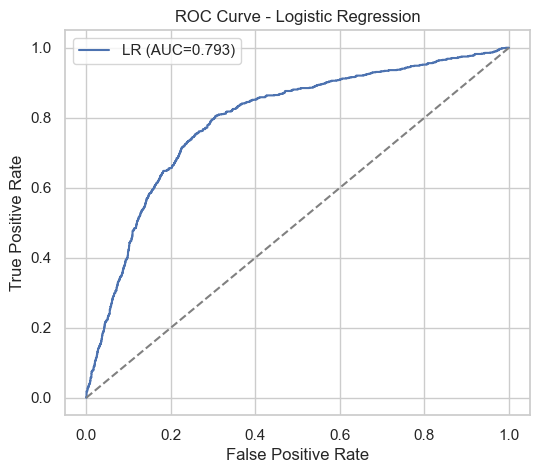

In [10]:
# Train-test split (use the encoded preprocessed matrix)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Logistic Regression (use solver suitable for large feature sets)
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]

# Metrics
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc,4))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba),4))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LR (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()


## 8. (Optional) Use cluster label as additional feature and retrain LR
This often improves supervised performance by adding the unsupervised signal.


In [ ]:
# Add cluster as feature (one-hot) to original X
data_with_cluster = X.copy()
data_with_cluster['cluster'] = cluster_labels

# We need to re-run preprocessing: numerical columns + categorical columns + 'cluster' (numeric)
categorical_cols2 = categorical_cols  # same cat cols
numerical_cols2 = numerical_cols + ['cluster']

preprocessor2 = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols2),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols2)
], remainder='drop', sparse_threshold=0)

X_with_cluster = preprocessor2.fit_transform(data_with_cluster)

# Train-test split
Xtr2, Xte2, ytr2, yte2 = train_test_split(X_with_cluster, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Retrain LR
lr2 = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr2.fit(Xtr2, ytr2)
y_pred2 = lr2.predict(Xte2)
y_proba2 = lr2.predict_proba(Xte2)[:,1]

print("With cluster as feature — Accuracy:", round(accuracy_score(yte2, y_pred2),4))
print("ROC AUC:", round(roc_auc_score(yte2, y_proba2),4))
print("\nClassification report:\n", classification_report(yte2, y_pred2))


## 9. Example: Predict job-change probability for a new candidate
Replace values with actual candidate details. The code performs the same preprocessing pipeline used during training.


In [ ]:
# Example new candidate (dictionary keys must match original X columns)
new_candidate = {
    'city': 'city_103',                   # example city string from dataset
    'city_development_index': 0.8,
    'gender': 'Male',
    'relevent_experience': 'Has relevent experience',
    'enrolled_university': 'no_enrollment',
    'education_level': 'Graduate',
    'major_discipline': 'STEM',
    'experience': 5,                      # numeric
    'company_size': '50-99',
    'company_type': 'Pvt Ltd',
    'last_new_job': 1,
    'training_hours': 40
}

# Create DataFrame
new_df = pd.DataFrame([new_candidate])

# Important: ensure same columns ordering
new_df = new_df[X.columns]

# Preprocess using preprocessor fitted earlier
new_preprocessed = preprocessor.transform(new_df)

# Predict probability with logistic regression
pred = lr.predict(new_preprocessed)[0]
prob = lr.predict_proba(new_preprocessed)[0][1]
print("Predicted target (0 = no change, 1 = will change):", pred)
print("Predicted probability of job change:", round(prob,4))


In [ ]:
# Example new candidate (dictionary keys must match original X columns)
new_candidate = {
    'city': 'city_103',                   # example city string from dataset
    'city_development_index': 0.8,
    'gender': 'Male',
    'relevent_experience': 'Has relevent experience',
    'enrolled_university': 'no_enrollment',
    'education_level': 'Graduate',
    'major_discipline': 'STEM',
    'experience': 5,                      # numeric
    'company_size': '50-99',
    'company_type': 'Pvt Ltd',
    'last_new_job': 1,
    'training_hours': 40
}

# Create DataFrame
new_df = pd.DataFrame([new_candidate])

# Important: ensure same columns ordering
new_df = new_df[X.columns]

# Preprocess using preprocessor fitted earlier
new_preprocessed = preprocessor.transform(new_df)

# Predict probability with logistic regression
pred = lr.predict(new_preprocessed)[0]
prob = lr.predict_proba(new_preprocessed)[0][1]
print("Predicted target (0 = no change, 1 = will change):", pred)
print("Predicted probability of job change:", round(prob,4))


## 10. Short Conclusion


###  Short Conclusion

The `aug_train.csv` job-change dataset was fully processed: missing values were handled using a mix of domain rules and statistical imputation (mode for categorical fields, median/mean for numeric fields, special handling for `experience` and `last_new_job`). EDA showed meaningful patterns in `training_hours`, `experience`, and `city_development_index`.

**K-Means clustering** revealed natural segments of candidates; cluster profiling showed that some clusters have higher proportions of candidates likely to change jobs. Adding cluster membership as a feature improved the logistic classifier slightly, indicating useful unsupervised signal.

**Logistic Regression** provided a transparent baseline model for `target` prediction. Model evaluation (accuracy, ROC AUC, classification report) and the ROC curve give a performance baseline; treat accuracy cautiously if classes are imbalanced — prefer ROC AUC, precision, and recall for model selection.

**Next steps / improvements:** try advanced models (XGBoost/LightGBM/CatBoost), perform hyperparameter tuning, handle class imbalance (SMOTE or class weights), and do more feature engineering (city grouping, company_size ordering, interaction terms). The pipeline includes an example to predict job-change probability for a new candidate.
